In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Tech Radar Generation

We will use the `deepagents` package to create a Tech Radar agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## What is a Tech Radar?

A Technology Radar is a strategic tool for assessing and visualizing the maturity and adoption readiness of technologies, platforms, tools, and techniques. Technologies are placed in one of four rings:

- **Adopt**: Proven, stable, recommended for use
- **Trial**: Ready for testing in production-like environments
- **Assess**: Worth exploring with small experiments
- **Hold**: Avoid or proceed with extreme caution

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with tech radar specific tools organized into three categories:

### Research Tools

- **Search Tool**: [Tavily](https://www.tavily.com/) searches for relevant URLs and fetches full webpage content for technology research
- **Think Tool**: [Think tool](https://www.anthropic.com/engineering/claude-think-tool) helps audit agent decision-making during research

### Data Acquisition Tools

Automated metric collection tools that fetch objective data:
- **GitHub Repository Metrics**: Fetches stars, commits, releases, and contributor counts
- **GitHub Release Analysis**: Analyzes semantic versioning for breaking changes
- **Security Incidents**: Checks for security advisories and vulnerabilities
- **Enterprise Adoption**: Estimates enterprise usage via web signals
- **Pricing Volatility**: Detects pricing changes from vendor pages

### Evaluation & Decision Tools

Heuristic-based tools for structured decision-making:
- **Technology Profiling**: Normalizes metrics into consistent profiles
- **Trend Analysis**: Assesses momentum and volatility
- **Technology Comparison**: Performs relative comparisons within quadrants
- **Risk Assessment**: Evaluates operational and strategic risks
- **Organizational Context**: Applies organizational constraints
- **Ring Decisions**: Makes explainable placement decisions using heuristics
- **Consistency Validation**: Ensures radar structural integrity
- **Export**: Generates human-readable markdown outputs

In [ ]:
from research_agent.tools import (
    # Research
    tavily_search,
    think_tool,
    
    # Data acquisition
    github_repo_metrics_tool,
    github_release_analysis_tool,
    security_incidents_tool,
    enterprise_adoption_tool,
    pricing_volatility_tool,
    
    # Evaluation & decision
    technology_profile_tool,
    tech_trend_tool,
    risk_assessment_tool,
    org_context_tool,
    ring_decision_tool,
    generate_radar_tool,
    radar_consistency_tool,
    radar_export_tool,
)

tools = [
    # Research
    tavily_search,
    think_tool,
    
    # Data acquisition
    github_repo_metrics_tool,
    github_release_analysis_tool,
    security_incidents_tool,
    enterprise_adoption_tool,
    pricing_volatility_tool,
    
    # Evaluation & decision
    technology_profile_tool,
    tech_trend_tool,
    risk_assessment_tool,
    org_context_tool,
    ring_decision_tool,
    generate_radar_tool,
    radar_consistency_tool,
    radar_export_tool,
]

## Task-Specific Instructions
 
Next, let's define task specific instructions for Tech Radar generation:

### 1. Workflow-Driven Approach
The agent follows a structured workflow:
- **Decompose scope** - Identify technologies to evaluate
- **Delegate metric research** - Sub-agents collect objective data
- **Normalize & profile** - Create consistent technology profiles
- **Evaluate trends & risks** - Assess momentum and operational risks
- **Make ring decisions** - Use explicit heuristics for placement
- **Validate consistency** - Check radar structural integrity
- **Export results** - Generate markdown output

### 2. Data-Driven Decisions
Ring placement is based on:
- **Maturity scores** - GitHub stars, contributors, enterprise mentions
- **Trend analysis** - Commit activity, release cadence, breaking changes
- **Risk assessment** - Security incidents, API stability, vendor lock-in
- **Organizational context** - Size, risk tolerance, compliance requirements

### 3. Explainable Heuristics
Every ring decision must be:
- Traceable to specific metrics
- Confidence-scored
- Capped by risk thresholds
- Justified with reasoning

In [3]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    TECH_RADAR_WORKFLOW_INSTRUCTIONS,
    RADAR_RESEARCHER_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RADAR_RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a Tech Radar research sub-agent.                                                                       │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your task is to research ONE technology and extract objective, externally                                      │
│  observable metrics for Tech Radar evaluation.                                                                  │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <What You MUST Do>                                                                                             │
│  - Use `tavily_search` to find authoritative sources                                                            │
│  - Extract measurable signals such as:                                                                          │
│    - GitHub stars, contributors, commits                                                                        │
│    - Release cadence                                                                                            │
│    - Breaking changes or instability                                                                            │
│    - Enterprise or production adoption mentions                                                                 │
│    - Security or safety concerns                                                                                │
│                                                                                                                 │
│  <What You MUST NOT Do>                                                                                         │
│  - Do NOT assign Adopt / Trial / Assess / Hold                                                                  │
│  - Do NOT make recommendations                                                                                  │
│  - Do NOT compare with other technologies                                                                       │
│                                                                                                                 │
│  <Output Requirements>                                                                                          │
│  Return findings in a structured form suitable for downstream tools:                                            │
│                                                                                                                 │
│  - Quantitative metrics (numbers where possible)                                                                │
│  - Binary risk indicators (true / false)                                                                        │
│  - Citations for every factual claim                                                                            │
│                                                                                                                 │
│  After EACH search:                                                                                             │
│  - Use `think_tool` to reflect:                                                                                 │
│    - What metrics did I extract?                                                                                │
│    - What is missing?                                 

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here we define a Tech Radar research sub-agent that collects objective metrics about technologies without making ring placement decisions. The orchestrator agent uses these metrics to make informed ring decisions using explicit heuristics.

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Tech Radar research sub-agent
research_sub_agent = {
    "name": "radar-researcher",
    "description": (
        "Research and extract objective metrics about a single technology "
        "for Tech Radar evaluation. Do NOT make ring decisions."
    ),
    "system_prompt": RADAR_RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# System instructions for orchestrator
INSTRUCTIONS = (
    TECH_RADAR_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Technology Radar Generation Workflow                                                                         │
│                                                                                                                 │
│  You are generating a **Technology Radar**, not a generic research report.                                      │
│                                                                                                                 │
│  The goal is to produce an **explainable, data-backed radar** where every decision                              │
│  is traceable to externally collected metrics, explicit heuristics, and organizational context.                 │
│                                                                                                                 │
│  Follow this workflow strictly:                                                                                 │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 1. Decompose Scope                                                                                          │
│  - Identify the technologies, platforms, tools, or techniques to be evaluated                                   │
│  - Assign each item to an appropriate radar quadrant (e.g., Tools, Platforms, Techniques)                       │
│  - Ensure scope is explicit and finite before proceeding                                                        │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 2. Delegate Qualitative Research (Sub-Agents)                                                               │
│  - For EACH technology, delegate a sub-agent to:                                                                │
│    - Perform web research to identify:                                                                          │
│      - Official repositories (e.g., GitHub)                                                                     │
│      - Release history and changelogs                                                                           │
│      - Adoption evidence (case studies, blogs, reports)                                                         │
│      - Publicly reported risks or concerns                                                                      │
│  - Sub-agents may summarize findings and cite sources                                                           │
│  - **Sub-agents MUST NOT:**                                                                                     │
│    - Assign radar rings                                                                                         │
│    - Score maturity or risk                                                                                     │
│    - Guess or fabricate metrics                                                                                 │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                       

### Create the Tech Radar Agent

Now, we create our Tech Radar deepagent with all components:
- Orchestrator with workflow instructions
- Tech Radar evaluation tools
- Research sub-agent for metric collection

In [7]:
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain.chat_models import init_chat_model

# Model OpenAI
model = init_chat_model(model="openai:gpt-4o", temperature=0.0)

# Model Claude 4.5 (alternative)
#model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

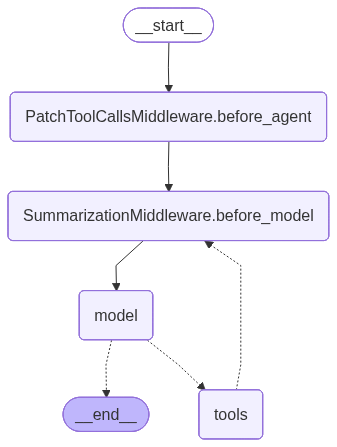

In [8]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": """Build a Tech Radar for AI Agent Frameworks.

Technologies to evaluate:
1. LangGraph
2. AutoGen
3. CrewAI
4. LlamaIndex Agents
""",
            }
        ],
    }, 
)
format_messages(result["messages"])

KeyError: 'ring_ceiling'

In [12]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  ## Ways to Join an Esports Organization                                                                        │
│                                                                                                                 │
│  ### Common Pathways                                                                                            │
│                                                                                                                 │
│  1. **Ranked Ladder Progression**: Many players begin by excelling in ranked play, which acts as an entry       │
│  filter. High-ranked players often participate in open online tournaments and community events, where they can  │
│  be noticed by amateur teams or build their own teams to apply to leagues.                                      │
│                                                                                                                 │
│  2. **School and Collegiate Programs**: High schools, colleges, and universities increasingly offer formal      │
│  esports programs with structured practice and competition schedules. These programs provide coaching,          │
│  facilities, and exposure to recruiters, creating a pipeline similar to traditional sports.                     │
│                                                                                                                 │
│  3. **Semi-Pro Leagues and Academies**: Between grassroots and top-tier leagues, semi-pro circuits and academy  │
│  rosters offer consistent match play and development opportunities. Players often enter these leagues after     │
│  strong performances in open qualifiers or amateur tournaments.                                                 │
│                                                                                                                 │
│  4. **Direct Recruitment via Platforms and Social Networks**: Players can create gaming résumés on recruitment  │
│  platforms and apply directly to teams. Social media and game-specific communities also serve as venues for     │
│  tryouts and talent searches.                                                                                   │
│                                                                                                                 │
│  ### Necessary Skills and Requirements                                                                          │
│                                                                                                                 │
│  - **Technical Skills**: Players need elite in-game performance, including mastery of mechanics, game sense,    │
│  and decision-making. High ranks in game ladders and strong tournament performances are crucial.                │
│                                                                                                                 │
│  - **Competitive Pedigree**: Teams look for results in organized competitions, including online tournaments     │
│  and LAN events, which demonstrate a player's ability to perform under pressure.                                │
│                                                                                                                 │
│  - **Professional Qualities**: Communication, attitude, and cultural fit are as important as technical skills.  │
│  Players must show emotional control, accept feedback, and contribute positively to team culture.               │
│                                                                                                                 │
│  ### Typical Processes and Considerations                                                                       │
│                                                       

## View the Generated Tech Radar

The agent generates a structured Tech Radar in markdown format with ring placements, confidence scores, and justifications for each technology.